In [1]:
import pandas as pd
import numpy as np 
import os
import imageio
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import cv2
from keras.applications.mobilenet import preprocess_input
from keras import backend as K
from keras.metrics import categorical_crossentropy
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense,GlobalAveragePooling2D, Dropout
from keras.applications import MobileNet, imagenet_utils
from keras.applications.mobilenet import preprocess_input
from keras.optimizers import Adam
from keras.layers import Input, Dense, Activation
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler

%matplotlib inline

Using TensorFlow backend.


In [2]:
train = pd.read_csv('train.csv', delimiter=',')
test = pd.read_csv('test.csv', delimiter=',')
train.set_index('image_id', inplace=True)

## Check if we have balanced data
- 3 out of 4 classes are equal 
- the class with multiple_diseases is undersampled

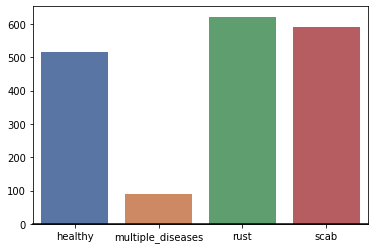

In [53]:
#count = train.groupby(['healthy','multiple_diseases', 'rust', 'scab'])['image_id'].count()
class_balance = sns.barplot(x=['healthy','multiple_diseases','rust','scab'], y=train.sum(), palette="deep",  ).axhline(0, color="k", clip_on=False)
class_balance = class_balance.get_figure()
class_balance.savefig('class_balance', dpi=400)

## Find out if all pictures have the same shape 
- most of the images have the shape (1365, 2048, 3)
- a list of pictures have the shape (2048, 1365, 3)

In [4]:
image = imageio.imread('images/Train_1.jpg')

In [155]:
shape_error = []
for i in tqdm(range(0,len(train.index))):
    image = imageio.imread(f'images/Train_{i}.jpg')
    if image.shape == (1365, 2048, 3):
        continue
    else:
        shape_error.append(f'Train_{i}.jpg')
        

100%|██████████| 1821/1821 [02:14<00:00, 13.52it/s]


In [156]:
# checking if all pictures in the list shape errors have the same shape
for i in tqdm(shape_error):
    image = imageio.imread(f'images/{i}')
    if image.shape == (2048, 1365, 3):
        continue

100%|██████████| 2/2 [00:00<00:00, 13.32it/s]


In [7]:
def reshaper(image):
    """Reshapes every picture to (224, 224, 3)"""
    if image.shape != (224, 224, 3):
        k = round(image.shape[0]/244), round(image.shape[1]/244)
        image = image[::k[0],::k[1],:]
        image = image[image.shape[0]-224:,((image.shape[1]-224)//2):-((image.shape[1]-224)//2),:]
    return image

## Split, reshape images 
- all images were shaped into (224, 224, 3)
- train and validation images were seperated in two different folders

In [8]:
for i in tqdm(range(0,len(train.index))):
    image = reshaper(imageio.imread(f'images/Test_{i}.jpg'))
    imageio.imwrite(f'test_data/Test_{i}.jpg',image)

In [ ]:
for i in tqdm(range(0,len(train.index))):
    image = reshaper(imageio.imread(f'images/Train_{i}.jpg'))
    imageio.imwrite(f'train_data/Train_{i}.jpg',image)

In [ ]:
def Scaler(X):
    """Flatten image, scales it, reshapes it"""
    min_max_scaler = MinMaxScaler()
    X = X.reshape(-1,3)
    X = min_max_scaler.fit_transform(X)
    X = X.reshape(224, 224, 3)
    return X

# Train-test-split
- 80% train data 
- 20% test data 

In [3]:
X = []
for i in tqdm(range(0,len(train.index))):
    image = imageio.imread(f'train_data/Train_{i}.jpg')
    X.append(image)
X = np.array(X)

100%|██████████| 1821/1821 [00:14<00:00, 124.32it/s]


In [4]:
# oversample the minority class
ros = RandomOverSampler(random_state=289)

x_res, y_res = ros.fit_resample(X.reshape((-1, 224 * 224 * 3)), train.values) #target.to_numpy())
x_res = x_res.reshape((-1, 224, 224, 3))

x_res.shape, y_res.sum(axis=0)

((2488, 224, 224, 3), array([622, 622, 622, 622]))

In [7]:
y =  train.values

In [8]:
X.shape

(1821, 224, 224, 3)

In [5]:
X = preprocess_input(x_res)
y =  y_res
Xtrain = X[:2000]
ytrain = y[:2000]
Xtest = X[2001:]
ytest = y[2001:]


In [10]:
Xtrain.shape

(1450, 224, 224, 3)

# Pretrained MobileNet 

In [ ]:
batch_size = [32]
epochs = [10]

rlr = ReduceLROnPlateau(patience=15, verbose=1)
es = EarlyStopping(patience=35, restore_best_weights=True, verbose=1)
mc = ModelCheckpoint('model.hdf5', save_best_only=True, verbose=0)


datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rescale=None,
    rotation_range=15,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True,
    zoom_range = 0.1,)

#training the image preprocessing
#datagen.fit(Xtrain, augment=True)


# fits the model on batches with real-time data augmentation:
for batch in batch_size:
    for epoch in epochs:
        K.clear_session()
        
        
        
        
        # load MobileNet
        customised_mobilenet = MobileNet(weights='imagenet' ,include_top=False, input_shape=(224,224,3))
        
        # add new layers
        new_layers = customised_mobilenet.output
        new_layers = GlobalAveragePooling2D()(new_layers)
        new_layers = Dense(1024, activation='relu')(new_layers)
        new_layers = Dense(512, activation='relu')(new_layers)
        new_layers = Dense(256, activation='relu')(new_layers)
        new_layers = Dropout(0.5)(new_layers)
        new_layers = Dense(4, activation='softmax')(new_layers)
        new_mobile = Model(inputs=customised_mobilenet.inputs, output=new_layers)
        
        # set number of trainable layers
        for i, layer in enumerate(new_mobile.layers):
            if i <= 100:
                layer.trainable = False
            else:
                layer.trainable = True
        
        # compile model
        new_mobile.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
        
        
        # fit and image generator
        
        history = new_mobile.fit_generator(
            datagen.flow(Xtrain, ytrain, batch_size = batch),
            validation_data = (Xtest, ytest),
            steps_per_epoch = len(Xtrain) // batch, 
            epochs = epoch,
            callbacks = [rlr, es , mc],
            use_multiprocessing = True,
             )
        
        # save model                               
        #new_mobile.save(f'model_batch_size:{batch}_epochs:{epoch}.h5')


        # evaluate the model
        _, train_acc = new_mobile.evaluate(Xtrain, ytrain, verbose=0)
        _, test_acc = new_mobile.evaluate(Xtest, ytest, verbose=0)
        print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
        # summarize history for accuracy
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title(f'model accuracy with {epoch} epochs and {batch} batch_size')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        #plt.savefig(f'accuracy:{epoch}epochs{batch}batch_size')
        plt.show()
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f'model loss with {epoch} epochs and {batch} batch_size')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        #plt.savefig(f'loss:{epoch}epochs{batch}batch_size')
        plt.show()

In [10]:
loaded_model = load_model('model1.hdf5')

In [11]:
Xval = []
for i in tqdm(range(0,1821)):
    image = imageio.imread(f'test_data/Test_{i}.jpg')
    image = image
    Xval.append(image)
Xval = np.array(Xval)
Xval = preprocess_input(Xval)



100%|██████████| 1821/1821 [00:12<00:00, 150.76it/s]


In [12]:
predictions = loaded_model.predict(Xval)

In [13]:
submissiondf = pd.concat([test, pd.DataFrame(predictions, columns=['healthy', 'multiple_diseases', 'rust', 'scab'])], axis=1)

In [14]:
submissiondf.to_csv('plant_pathology', sep=',', index=False)

In [15]:
loaded_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 